# Import Libraries & Dependencies

In [2]:
#import libraries and dependencies

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from numpy import mean
from numpy import std
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [4]:
#Create connection to postgres database EmployeeSQL
# load_dotenv()
# my_env_var = os.getenv('DB_CONNECTION_STRING')
# engine = create_engine(my_env_var)
# connection = engine.connect()
# connection

#connect engine
###note to group, update local host location and name of database to reflect what is on your system
connection_string = "postgres:postgres@localhost:5432/final_project"
engine = create_engine(f'postgresql://{connection_string}')

In [7]:
real_estateFinal_df = pd.read_sql('SELECT * FROM "real_estate_final"', engine)
pd.set_option('display.max_columns', None)
real_estateFinal_df.sample(5)

,index,address,neighborhood,borough,bed,bath,days_on_market,compass_property_type,compass_property_type_int,mls_property_subtype,mls_property_type,listed_price,sold_price,sold_date,zipcode,lat,long,year_built,dom_ranges,dom_tier,dom_lowerbound,dom_iqr,dom_upperbound,dom_extended,dom_outlier,walkable_false,walkable_true,health_level_dead,health_level_fair,health_level_good,health_level_poor,ada_access_no,ada_access_yes,ada_access_partial,type_is_active_cleanup_mild_threat,type_is_active_significant_threat,type_is_completed_clean,type_is_maintain_continued_threat,type_is_potential_threat,type_is_felony,type_is_violation,type_is_misdemeanor,danger_level_is_high,danger_level_is_low,lunch_eligibity_high_false_elem,lunch_eligibity_high_true_elem,type_is_top_25th_percentile_elem,type_is_50th_percentile_elem,type_is_75th_percentile_elem,type_is_bottom_25th_percentile_elem,lunch_eligibity_high_false_middle,lunch_eligibity_high_true_middle,type_is_top_25th_percentile_middle,type_is_50th_percentile_middle,type_is_75th_percentile_middle,type_is_bottom_25th_percentile_middle,lunch_eligibity_high_false_high,lunch_eligibity_high_true_high,type_is_top_25th_percentile_high,type_is_50th_percentile_high,type_is_75th_percentile_high,type_is_bottom_25th_percentile_high
31215,31214,1518 57th st,borough park,brooklyn,9,5,105,townhouse,4,three family/all multi family,townhouse,0.0,995000.0,2020-07-02,11219,40.6311,-73.9977,1931-01-01,55-105,1,0,1,0,0,0,0,169,201,530,3590,142,2,0,0,0,0,0,0,0,106,44,159,27,282,0,6,5,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1
22581,22572,106-24 173rd st,jamaica,queens,1,1,105,townhouse,4,two family/all multi family,townhouse,0.0,570000.0,2020-05-12,11433,40.6998,-73.7860,1930-01-01,55-105,1,0,1,0,0,0,0,295,216,429,2962,138,0,1,0,0,1,0,0,1,162,78,231,49,422,1,4,0,1,3,1,2,3,0,2,2,1,2,0,1,0,1,0
16326,16318,"167-10 crocheron ave, unit 4p",murray hill - flushing,queens,1,1,105,co-op,2,0,co-op,0.0,328000.0,2020-04-27,11358,40.7607,-73.7978,1938-01-01,55-105,1,0,1,0,0,0,325,0,254,606,5901,167,0,0,0,1,0,0,0,0,19,29,44,6,86,1,1,1,1,0,0,2,0,0,2,0,0,1,0,0,0,1,0
25154,25150,87-09 159th ave,rockwood park,queens,1,1,105,townhouse,4,single family,townhouse,0.0,655000.0,2020-11-19,11414,40.6617,-73.8478,1950-01-01,55-105,1,0,1,0,0,0,0,392,269,709,3487,185,1,1,0,0,0,1,0,0,62,21,69,17,135,3,0,1,2,0,0,3,0,0,3,0,0,0,0,0,0,0,0
23141,23133,64-16 beach channel dr,arverne,queens,3,3,80,townhouse,4,all multi family/two family/single family,townhouse,509000.0,480000.0,2020-07-06,11692,40.5927,-73.7978,2005-01-01,55-105,1,0,1,0,0,0,0,118,150,523,1122,218,1,0,0,1,0,0,0,0,94,39,120,16,237,1,1,0,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0


## Random Forest Classifier Model

This model will classify the property type based on all the features selected in the X value.

In [8]:
#assign X values (independent variable) from the Real Estate Final table for the model - cast all as int 
X = real_estateFinal_df[['zipcode', 'sold_price','bed', 'bath', 'days_on_market', 'dom_tier', 'dom_lowerbound', 'dom_iqr', 'dom_upperbound','dom_extended', 
            'dom_outlier', 'walkable_false', 'walkable_true', 'health_level_dead', 'health_level_fair', 'health_level_good',
            'health_level_poor', 'ada_access_no', 'ada_access_yes', 'ada_access_partial', 
            'type_is_active_cleanup_mild_threat','type_is_active_significant_threat','type_is_completed_clean',
            'type_is_maintain_continued_threat', 'type_is_potential_threat', 'type_is_felony', 'type_is_violation', 
            'type_is_misdemeanor', 'danger_level_is_high', 'danger_level_is_low', 'lunch_eligibity_high_false_elem',
            'lunch_eligibity_high_true_elem', 'type_is_top_25th_percentile_elem', 'type_is_50th_percentile_elem',
            'type_is_75th_percentile_elem', 'type_is_bottom_25th_percentile_elem', 'lunch_eligibity_high_false_middle',
            'lunch_eligibity_high_true_middle', 'type_is_top_25th_percentile_middle', 'type_is_50th_percentile_middle',
            'type_is_75th_percentile_middle', 'type_is_bottom_25th_percentile_middle', 'lunch_eligibity_high_false_high',
            'lunch_eligibity_high_true_high', 'type_is_top_25th_percentile_high', 'type_is_50th_percentile_high',
            'type_is_75th_percentile_high', 'type_is_bottom_25th_percentile_high']]

X.astype(int)

,zipcode,sold_price,bed,bath,days_on_market,dom_tier,dom_lowerbound,dom_iqr,dom_upperbound,dom_extended,dom_outlier,walkable_false,walkable_true,health_level_dead,health_level_fair,health_level_good,health_level_poor,ada_access_no,ada_access_yes,ada_access_partial,type_is_active_cleanup_mild_threat,type_is_active_significant_threat,type_is_completed_clean,type_is_maintain_continued_threat,type_is_potential_threat,type_is_felony,type_is_violation,type_is_misdemeanor,danger_level_is_high,danger_level_is_low,lunch_eligibity_high_false_elem,lunch_eligibity_high_true_elem,type_is_top_25th_percentile_elem,type_is_50th_percentile_elem,type_is_75th_percentile_elem,type_is_bottom_25th_percentile_elem,lunch_eligibity_high_false_middle,lunch_eligibity_high_true_middle,type_is_top_25th_percentile_middle,type_is_50th_percentile_middle,type_is_75th_percentile_middle,type_is_bottom_25th_percentile_middle,lunch_eligibity_high_false_high,lunch_eligibity_high_true_high,type_is_top_25th_percentile_high,type_is_50th_percentile_high,type_is_75th_percentile_high,type_is_bottom_25th_percentile_high
0,10011,1646000,1,2,75,1,0,1,0,0,0,0,85,94,195,1769,76,5,2,0,1,0,10,0,1,664,200,924,252,1536,4,0,4,0,0,0,3,0,1,1,1,0,3,4,1,1,1,4
1,10023,799000,1,1,60,1,0,1,0,0,0,0,104,57,375,1756,72,2,2,0,0,0,3,0,0,339,158,971,151,1317,4,0,3,0,1,0,3,0,1,1,0,1,3,3,2,1,0,3
2,10025,670000,1,1,122,2,0,0,1,0,0,0,64,126,576,2796,198,4,1,0,1,0,0,0,0,401,177,891,169,1300,5,1,3,2,0,1,4,3,0,4,2,1,0,0,0,0,0,0
3,10011,2175000,2,4,72,1,0,1,0,0,0,0,85,94,195,1769,76,5,2,0,1,0,10,0,1,664,200,924,252,1536,4,0,4,0,0,0,3,0,1,1,1,0,3,4,1,1,1,4
4,10024,2333000,2,3,134,2,0,0,1,0,0,0,67,80,370,2763,98,3,0,0,0,0,2,0,0,130,78,191,42,357,5,0,5,0,0,0,4,1,3,2,0,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37223,11235,230000,1,1,105,1,0,1,0,0,0,1,467,394,1276,3228,259,11,1,0,3,0,3,0,0,42,28,60,7,123,2,4,3,2,1,0,1,3,1,2,1,0,2,5,1,0,0,6
37224,11235,2050000,7,5,105,1,0,1,0,0,0,1,467,394,1276,3228,259,11,1,0,3,0,3,0,0,42,28,60,7,123,2,4,3,2,1,0,1,3,1,2,1,0,2,5,1,0,0,6
37225,11235,800000,8,1,105,1,0,1,0,0,0,1,467,394,1276,3228,259,11,1,0,3,0,3,0,0,42,28,60,7,123,2,4,3,2,1,0,1,3,1,2,1,0,2,5,1,0,0,6
37226,11235,940000,8,4,105,1,0,1,0,0,0,1,467,394,1276,3228,259,11,1,0,3,0,3,0,0,42,28,60,7,123,2,4,3,2,1,0,1,3,1,2,1,0,2,5,1,0,0,6


In [9]:
#assign Y value (dependent variable) from the Real Estate Final table for the model
y = real_estateFinal_df[['compass_property_type']]
y.dtypes

compass_property_type    object
dtype: object

In [10]:
#Run test and train of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
#Run the Random Forest Classifier and then fit it to the x and y train data - also score the x and y test data
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_features="log2", min_samples_split=3, min_samples_leaf=2)
rf = rf.fit(X_train, y_train.values.ravel())
rf.score(X_test, y_test)

0.8750402922531428

In [8]:
#show the importance of the x features
sorted(zip(rf.feature_importances_, X.columns), reverse=True)

[(0.2272002730017783, 'sold_price'),
 (0.17355187331064453, 'bed'),
 (0.09169473124279985, 'bath'),
 (0.05514518473816878, 'days_on_market'),
 (0.03261131412222132, 'zipcode'),
 (0.029717386193310054, 'health_level_dead'),
 (0.02480177189555674, 'health_level_good'),
 (0.02467307022120609, 'walkable_true'),
 (0.02166587866176877, 'type_is_completed_clean'),
 (0.02035665185775699, 'type_is_misdemeanor'),
 (0.019280139869923916, 'type_is_active_cleanup_mild_threat'),
 (0.01837513734940911, 'health_level_poor'),
 (0.01661551975271171, 'health_level_fair'),
 (0.01499376144454424, 'danger_level_is_high'),
 (0.014692293165858685, 'danger_level_is_low'),
 (0.013845168778965735, 'type_is_felony'),
 (0.013561769317808595, 'type_is_violation'),
 (0.012186459169749399, 'dom_iqr'),
 (0.01134932015709387, 'dom_tier'),
 (0.011217800998060872, 'lunch_eligibity_high_false_elem'),
 (0.010440966685941503, 'walkable_false'),
 (0.01018766749060923, 'type_is_bottom_25th_percentile_elem'),
 (0.0097337145436

In [12]:
#make prediction from model
y_pred = rf.predict(X_test)

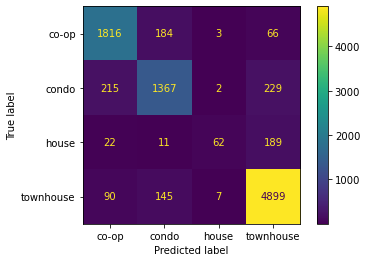

In [13]:
#evaluate the classification made by the model by declaring a confusion matrix
confusion_matrix(y_test, y_pred)
plot_confusion_matrix(rf,X_test,y_test)

In [14]:
#generate a classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       co-op       0.85      0.88      0.86      2069
       condo       0.80      0.75      0.78      1813
       house       0.84      0.22      0.35       284
   townhouse       0.91      0.95      0.93      5141

    accuracy                           0.88      9307
   macro avg       0.85      0.70      0.73      9307
weighted avg       0.87      0.88      0.87      9307



## Random Forest Regression

In [15]:
#assign X values from the Real Estate Final table for the model - cast all as int 
X1 = real_estateFinal_df[['zipcode','bed', 'bath', 'days_on_market', 'compass_property_type_int','listed_price',
            'dom_outlier', 'walkable_false', 'walkable_true', 'health_level_dead', 'health_level_fair', 'health_level_good',
            'health_level_poor', 'ada_access_no', 'ada_access_yes', 'ada_access_partial', 
            'type_is_active_cleanup_mild_threat','type_is_active_significant_threat','type_is_completed_clean',
            'type_is_maintain_continued_threat', 'type_is_potential_threat', 'type_is_felony', 'type_is_violation', 
            'type_is_misdemeanor', 'danger_level_is_high', 'danger_level_is_low', 'lunch_eligibity_high_false_elem',
            'lunch_eligibity_high_true_elem', 'type_is_top_25th_percentile_elem', 'type_is_50th_percentile_elem',
            'type_is_75th_percentile_elem', 'type_is_bottom_25th_percentile_elem', 'lunch_eligibity_high_false_middle',
            'lunch_eligibity_high_true_middle', 'type_is_top_25th_percentile_middle', 'type_is_50th_percentile_middle',
            'type_is_75th_percentile_middle', 'type_is_bottom_25th_percentile_middle', 'lunch_eligibity_high_false_high',
            'lunch_eligibity_high_true_high', 'type_is_top_25th_percentile_high', 'type_is_50th_percentile_high',
            'type_is_75th_percentile_high', 'type_is_bottom_25th_percentile_high']]

# X1 = real_estateFinal_df[['zipcode','bed', 'bath', 'days_on_market', 'health_level_dead','ada_access_yes', 
#             'type_is_completed_clean', 'compass_property_type_int']]


X1.astype(int)

#assign Y value (dependent variable) from the Real Estate Final table for the model
y1 = real_estateFinal_df[['sold_price']]

In [13]:
#Run test and train of the data
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state = 101)

#Run the Random Forest Regression and then fit it to the x and y train data
model = RandomForestRegressor(n_estimators = 2000, max_depth = 200)
model.fit(X_train, y_train.values.ravel())

filename = '../finalized_model.pkl'

with open(filename, 'wb') as file:
    pickle.dump(model, file)

In [14]:
#make prediction from model
y1_pred = model.predict(X_test)

#X_test
pd.set_option('display.float_format', lambda x: '%.3f' % x)
result_regression = X_test
result_regression['sold_price'] = y_test
result_regression['y1_pred'] = y1_pred.tolist()
result_regression.sample(20)

<ipython-input-14-a91de3911ed3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_regression['sold_price'] = y_test
<ipython-input-14-a91de3911ed3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_regression['y1_pred'] = y1_pred.tolist()


,zipcode,bed,bath,days_on_market,compass_property_type_int,listed_price,dom_outlier,walkable_false,walkable_true,health_level_dead,health_level_fair,health_level_good,health_level_poor,ada_access_no,ada_access_yes,ada_access_partial,type_is_active_cleanup_mild_threat,type_is_active_significant_threat,type_is_completed_clean,type_is_maintain_continued_threat,type_is_potential_threat,type_is_felony,type_is_violation,type_is_misdemeanor,danger_level_is_high,danger_level_is_low,lunch_eligibity_high_false_elem,lunch_eligibity_high_true_elem,type_is_top_25th_percentile_elem,type_is_50th_percentile_elem,type_is_75th_percentile_elem,type_is_bottom_25th_percentile_elem,lunch_eligibity_high_false_middle,lunch_eligibity_high_true_middle,type_is_top_25th_percentile_middle,type_is_50th_percentile_middle,type_is_75th_percentile_middle,type_is_bottom_25th_percentile_middle,lunch_eligibity_high_false_high,lunch_eligibity_high_true_high,type_is_top_25th_percentile_high,type_is_50th_percentile_high,type_is_75th_percentile_high,type_is_bottom_25th_percentile_high,sold_price,y1_pred
37189,11214,1,1.000,32,1,420000.000,0,0,254,191,536,3512,102,5,2,0,1,0,3,0,1,132,94,234,71,389,1,7,2,5,1,0,1,4,0,4,1,0,1,5,0,1,3,2,396800.000,430606.236
11127,11234,0,1.000,105,4,0.000,0,546,0,415,1270,9227,341,1,2,0,0,0,8,0,1,48,62,101,10,201,7,1,3,3,1,1,2,1,0,1,2,0,0,0,0,0,0,0,337098.000,308792.630
22968,11355,2,2.000,249,1,639000.000,0,0,523,294,662,4125,206,0,0,0,4,0,6,0,0,78,64,98,22,218,2,2,3,1,0,0,0,3,0,3,0,0,0,1,0,1,0,0,550000.000,575139.161
25277,11364,1,1.000,29,2,249999.000,0,516,0,323,923,5555,253,0,0,0,0,0,0,0,0,19,13,29,6,55,4,0,4,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,240000.000,240356.731
1070,10028,6,5.500,288,1,12901980.000,0,0,40,91,354,1229,132,0,1,0,0,0,1,0,0,0,0,0,0,0,2,0,2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,13927602.000,10745570.284
23734,11101,3,2.000,52,1,1925000.000,0,0,582,142,623,2429,193,11,3,0,28,6,68,0,5,193,121,261,60,515,1,2,0,1,1,1,2,2,0,3,0,1,4,6,3,1,5,1,1825000.000,1876054.329
27780,11235,1,1.000,105,4,0.000,0,1,467,394,1276,3228,259,11,1,0,3,0,3,0,0,42,28,60,7,123,2,4,3,2,1,0,1,3,1,2,1,0,2,5,1,0,0,6,805000.000,705618.378
2182,10469,4,2.500,45,4,470000.000,0,0,365,392,731,5378,209,2,1,0,3,0,2,0,0,110,84,188,36,346,1,5,1,0,3,2,0,3,0,0,3,0,0,5,0,0,1,4,470000.000,465316.998
5547,10307,3,2.000,62,4,489000.000,0,0,192,149,578,4548,176,2,2,0,0,0,2,0,0,7,9,10,1,25,2,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,460000.000,459326.731
20379,11365,6,3.000,62,4,989000.000,0,262,0,300,925,5959,244,0,0,0,0,0,4,0,1,38,26,90,11,143,3,1,3,1,0,0,2,0,0,2,0,0,1,0,0,1,0,0,950000.000,932516.521


In [15]:
#score the y test data vs the predicted data
r2 = r2_score(y_test, y1_pred)
r2
print('R-squared scores:', round(r2, 3))

R-squared scores: 0.842


In [16]:
y_test, y1_pred

(       sold_price
 11228  340000.000
 9028   460000.000
 16967  800000.000
 30571  256470.000
 13051  372500.000
 ...           ...
 19278  497500.000
 22170  225000.000
 12773  507500.000
 6347   595000.000
 2125   380250.000
 
 [9307 rows x 1 columns],
 array([314929.40910892, 462230.11      , 777427.68029167, ...,
        507249.943     , 567205.115     , 526805.33051282]))

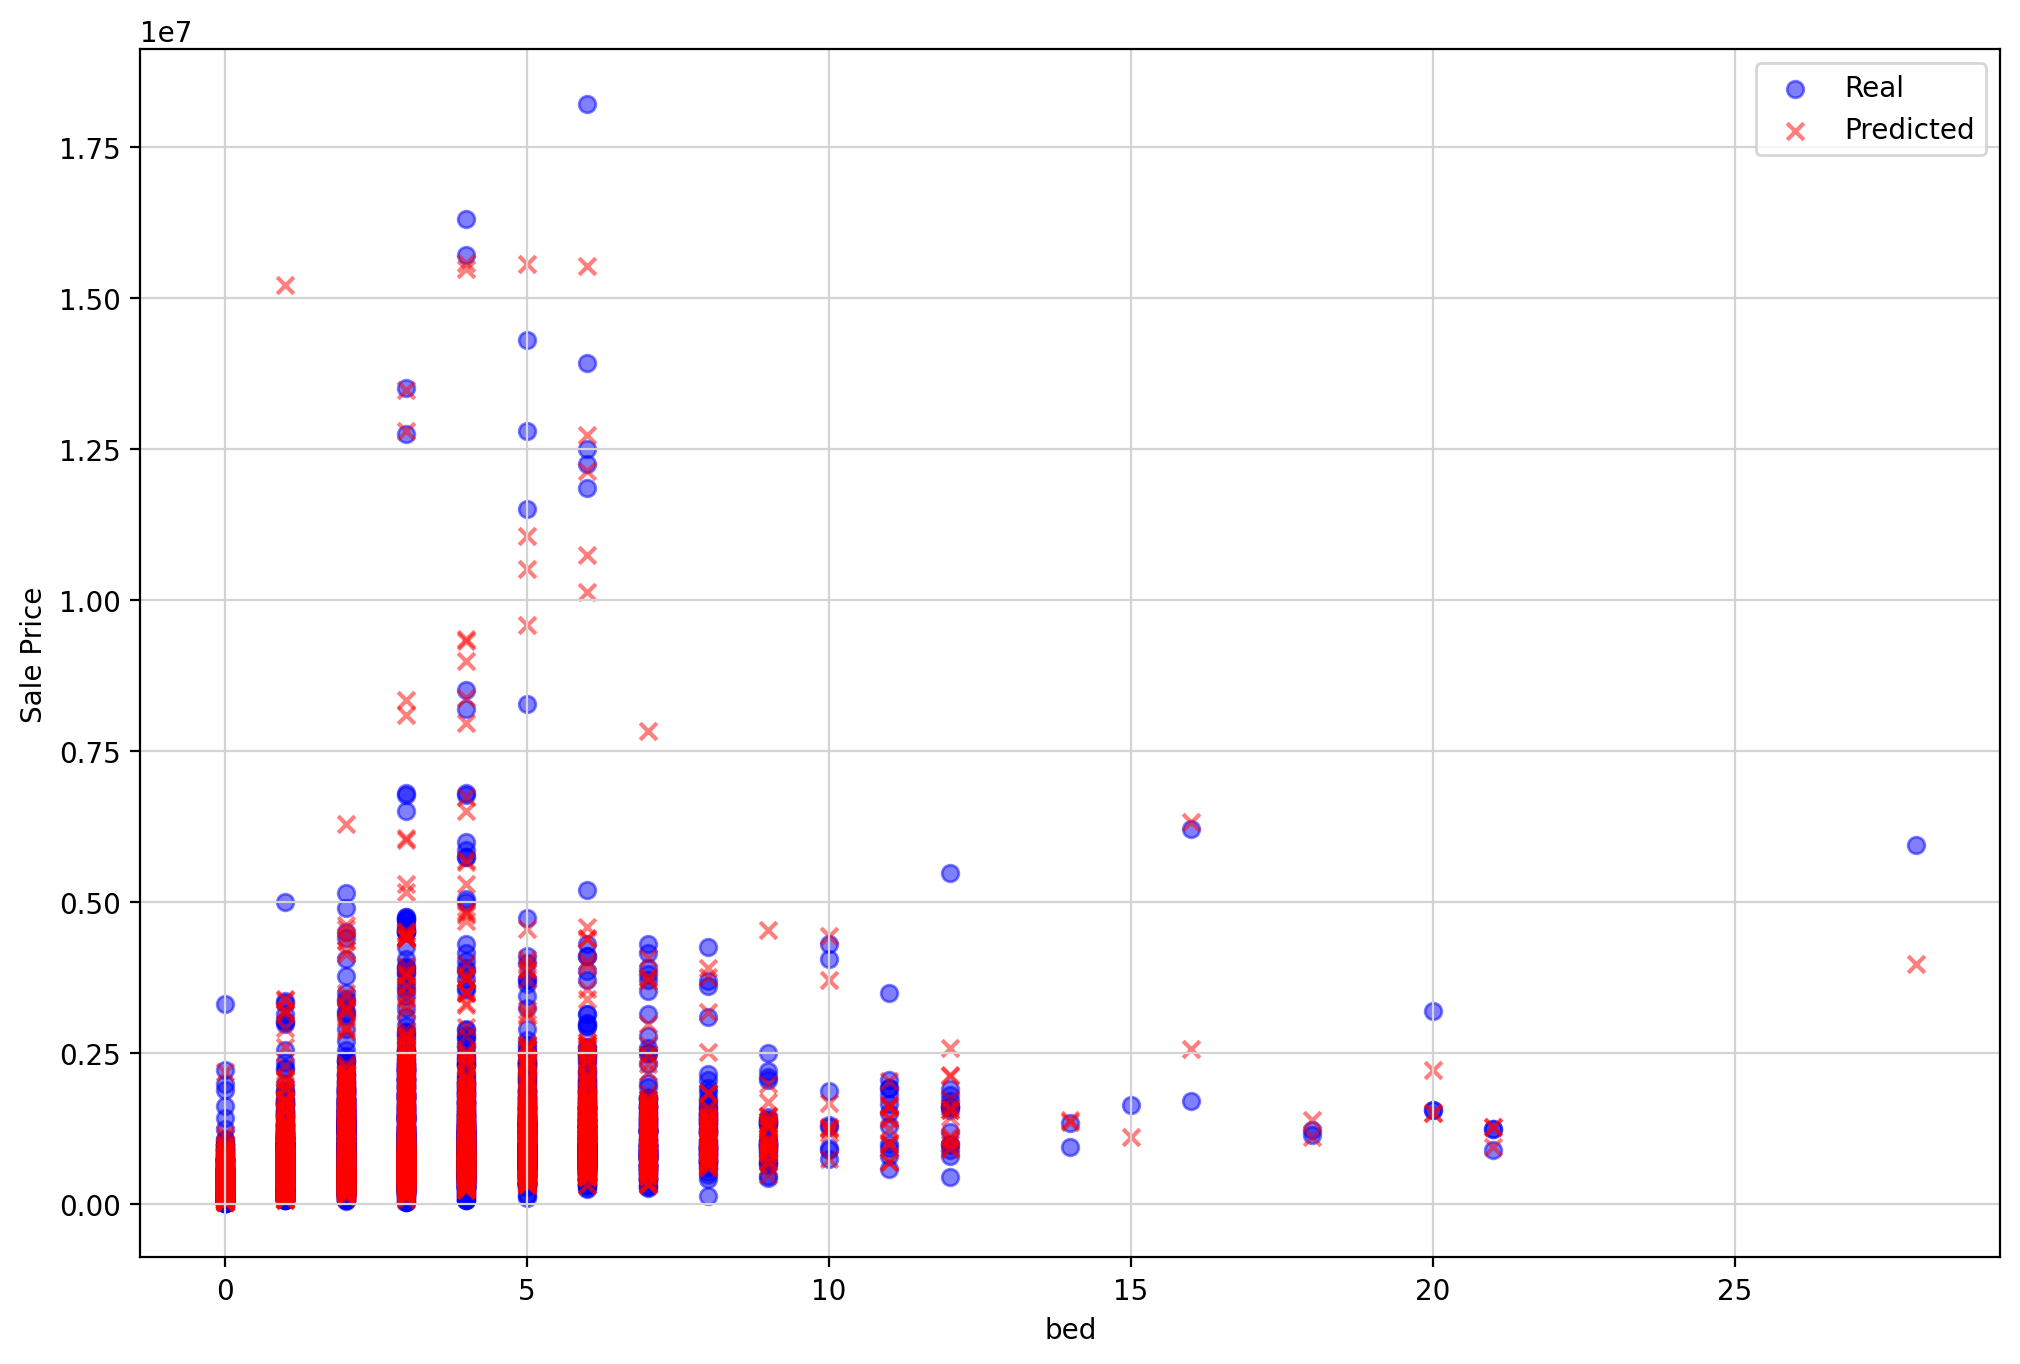

In [17]:
import matplotlib.ticker as ticker

# Define x axis
x_axis = X_test.bed

# fig, ax = plt.subplots()

# # Be sure to only pick integer tick locations.
# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_locator(ticker.MaxNLocator(integer=True))

# yticks(ticks=y1, labels=None, **kwargs)[source]

# Build scatterplot
plt.figure(figsize=(12,8),dpi=200)
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = 'o', label = 'Real')
plt.scatter(x_axis, y1_pred, c = 'r', alpha = 0.5, marker = 'x', label = 'Predicted')
plt.xlabel('bed')
plt.ylabel('Sale Price')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'upper right')
plt.show()

In [18]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error
# # Mean absolute error (MAE)
# mae = mean_absolute_error(y_test.values.ravel(), y1_pred)

# # Mean squared error (MSE)
# mse = mean_squared_error(y_test.values.ravel(), y1_pred)

print('MAE:\t$%.2f' % mean_absolute_error(y_test.values.ravel(), y1_pred))
print('MSLE:\t%.5f' % mean_squared_log_error(y_test.values.ravel(), y1_pred))
print('MSE:\t%.5f' % mean_squared_error(y_test.values.ravel(), y1_pred))

# # Print metrics
# print('Mean Absolute Error:', round(mae, 2))
# print('Mean Squared Error:', round(mse, 2))

MAE:	$81531.87
MSLE:	0.08175
MSE:	87749665781.78534


### This cell should only be run to perform tuning of the algorithm. One tool used to do this is GridSearchCV method which will obtain the best parameters for the algorithm. Takes forever to run.
from sklearn.model_selection import GridSearchCV

#Find the best parameters for the model
parameters = {
    'max_depth': [70, 80, 90, 100],
    'n_estimators': [900, 1000, 1100]
}
gridforest = GridSearchCV(model, parameters, cv = 3, n_jobs = -1, verbose = 1)
gridforest.fit(X_train, y_train)
gridforest.best_params_

In [19]:
# Get features list
characteristics = X1.columns

In [20]:
# Get the variables importances, sort them, and print the result
importances = list(model.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: listed_price         Importance: 0.75
Variable: bath                 Importance: 0.05
Variable: zipcode              Importance: 0.04
Variable: bed                  Importance: 0.04
Variable: compass_property_type_int Importance: 0.02
Variable: days_on_market       Importance: 0.01
Variable: walkable_true        Importance: 0.01
Variable: dom_outlier          Importance: 0.0
Variable: walkable_false       Importance: 0.0
Variable: health_level_dead    Importance: 0.0
Variable: health_level_fair    Importance: 0.0
Variable: health_level_good    Importance: 0.0
Variable: health_level_poor    Importance: 0.0
Variable: ada_access_no        Importance: 0.0
Variable: ada_access_yes       Importance: 0.0
Variable: ada_access_partial   Importance: 0.0
Variable: type_is_active_cleanup_mild_threat Importance: 0.0
Variable: type_is_active_significant_threat Importance: 0.0
Variable: type_is_completed_clean Importance: 0.0
Variable: type_is_maintain_continued_threat Importance: 0.0
Varia

In [34]:
# %matplotlib qt
width = 15
height = 20
fig = plt.figure(figsize=(width, height))

ax = fig.add_subplot(111, projection='3d')

xs = real_estateFinal_df[['bed']]
ys =real_estateFinal_df[['sold_price']]
zs =real_estateFinal_df[['bath']]

ax.scatter(xs, ys, zs, marker='o', cmap=cmap, alpha=1)

ax.set_xlabel('Bedrooms')
ax.set_ylabel('Sold Price')
ax.set_zlabel('Bathrooms')

plt.show()

ValueError: could not convert string to float: 'manhattan'

TypeError: can't multiply sequence by non-int of type 'float'

<Figure size 1080x1440 with 1 Axes>

In [35]:
import plotly.express as px

fig = px.scatter_3d(real_estateFinal_df, x='bed', y='sold_price', 
                    z='borough', color = 'borough', size_max=18, opacity=0.7)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))